# Variational Autoencoders on Poor Sevens 

### Problem definition

1. <p style='text-align: justify;'> tr7.pk1 contains 6,265 MNIST digits from its training set, but not all ten digits. I only selected 7's. Therefore, it's with a rank-3 tensor of size 6,265x28x28. Similarly, te7.pk1 contains 1,028 7's. </p>


2. <p style='text-align: justify;'> The digit images in this problem are special, because I added a special effect to them. So, they are different from the original 7's in the MNIST dataset in a way. I want you to find out what I did to the poor 7's. </p>


3. <p style='text-align: justify;'> Instead of eyeballing all those images, you need to implement a <b>VAE</b> that finds out a few latent dimensions, one of which should show you the effect I added. </p>


4. <p style='text-align: justify;'> Once again, I wouldn't care too much about your network architecture. This could be a good chance for you to check out the performance of the CNN encoder, followed by a decoder with deconvolution layers (or transposed convolution layers), but do something else if you feel like. I found that fully-connected networks work just fine. </p>


5. <p style='text-align: justify;'> What's important here in the VAE is, as a VAE, it needs a hidden layer that is dedicated to learn the latent embedding. In this layer. each hidden unit is governed by a standard normal distribution as its a priori information. Also. be careful about the re-parameterization technique and the loss function. </p>


6. <p style='text-align: justify;'> You'll need to limit the number of hidden units <i>K</i> in your code layer (the embedding vector) with a small number (e.g. smaller than 5) to reduce your search space. Out of <i>K</i>, there must be a dimension that explains the effect that I added. </p>


7. <p style='text-align: justify;'> One way to prove that you found the latent dimension of interest is to show me the digits generated by the decoder. More specifically. you may want to "generate" new 7's by feeding a few randomly generated code vectors, that are the random samples from the <i>K</i> normal distributions that your VAE learned. But, they won't be enough to show which dimension takes care of my added effect. Therefore, your random code vectors should be formed specially. </p>


8. <p style='text-align: justify;'> What I'd do is to generate code vectors by fixing the <i>K</i>-1 dimensions with the same value over the codes, while varying only one of them. </p>


9. <p style='text-align: justify;'> For example. if <i>K</i> = 3 and you're interested in the third dimension, your codes should look like as follows: 
$$ Z  = \begin{vmatrix}
        \,0.23 & -0.18 & -5.0\,\\
        \,0.23 & -0.18 & -4.5\,\\
        \,0.23 & -0.18 & -4.0\,\\
        \,0.23 & -0.18 & -3.5\,\\
        \,0.23 & -0.18 & -3.0\,\\
         & \,\,⋮ & \\
        \,0.23 & -0.18 & 4.5\\
        \,0.23 & -0.18 & 5.0\\       
\end{vmatrix}$$ 
    
    Note that the first two column vectors are once randomly sampled from the normal distributions, but then shared by all the codes so that the variation found in the decoded output relies solely on the third dimension. </p>


10. <p style='text-align: justify;'> You'll want to examine all the K dimensions by generating samples from each of them. Show me the ones you like. They should show a bunch of <b>similar-looking</b> 7's but with <b>gradually changing effect</b> on them. The generated samples that show a gradual change of the thickness of the stroke. for example. are not a good answer, because that's not the one I added. but something that was there in the dataset already. </p>

-----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline

import torch
import random
import numpy as np
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available.')

No GPU available.


## Loading and merging data

In [4]:
with open('/content/drive/MyDrive/DeepLearning/te7.pkl', 'rb') as f:
    te7 = pkl.load(f)

with open('/content/drive/MyDrive/DeepLearning/tr7.pkl', 'rb') as f:
    tr7 = pkl.load(f)

In [5]:
print('te7 shape:', te7.shape)
print('tr7 shape:', tr7.shape)

te7 shape: (1028, 28, 28)
tr7 shape: (6265, 28, 28)


In [6]:
poor_sevens = np.concatenate((te7, tr7), axis=0)
print('poor_sevens shape:', poor_sevens.shape)

poor_sevens shape: (7293, 28, 28)


In [7]:
num_workers = 0
batch_size = 100

#poor_sevens = np.concatenate((te7, tr7), axis=0)
poor_sevens = torch.from_numpy(poor_sevens)

data_loader = torch.utils.data.DataLoader(poor_sevens, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)        

## Visualizing poor sevens

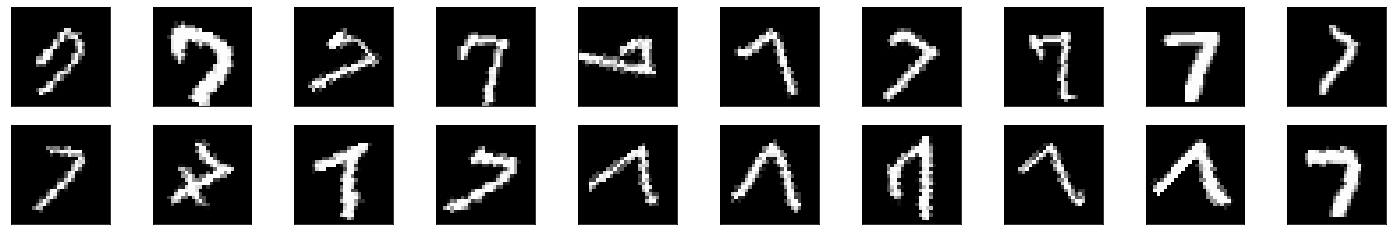

In [8]:
random_factor = random.randint(0, poor_sevens.shape[0]-20) # to show different subset from the dataset each run

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(poor_sevens[idx+random_factor]), cmap='gray')

In [9]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder layers
        self.fc1_e = nn.Linear(x_dim, h_dim1)
        self.fc2_e = nn.Linear(h_dim1, h_dim2)
        self.fc31_e = nn.Linear(h_dim2, z_dim)
        self.fc32_e = nn.Linear(h_dim2, z_dim)
        
        # decoder layers
        self.fc1_d = nn.Linear(z_dim, h_dim2)
        self.fc2_d = nn.Linear(h_dim2, h_dim1)
        self.fc3_d = nn.Linear(h_dim1, x_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self, x):
        x = self.relu(self.fc1_e(x))
        x = self.relu(self.fc2_e(x))
        mu = self.fc31_e(x)
        log_var = self.fc32_e(x)
        return mu, log_var # return µ, σ
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        x = self.relu(self.fc1_d(z))
        x = self.relu(self.fc2_d(x))
        x = self.sigmoid(self.fc3_d(x)) 
        return x
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        x = self.decoder(z)

        return x , mu, log_var

In [10]:
# build model
vae = VAE(x_dim=28*28, h_dim1= 512, h_dim2=256, z_dim=3)
if(train_on_gpu):
    vae.cuda()

print(vae)

VAE(
  (fc1_e): Linear(in_features=784, out_features=512, bias=True)
  (fc2_e): Linear(in_features=512, out_features=256, bias=True)
  (fc31_e): Linear(in_features=256, out_features=3, bias=True)
  (fc32_e): Linear(in_features=256, out_features=3, bias=True)
  (fc1_d): Linear(in_features=3, out_features=256, bias=True)
  (fc2_d): Linear(in_features=256, out_features=512, bias=True)
  (fc3_d): Linear(in_features=512, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


$$ Loss = reconstruction \, error \,  + \,  Kullback-Leibler \,  divergence \,  loss$$
$$ Loss = [\sum_{i=1}^{n} (x_i - recon\_x_i)^2] \, + [-{1\over2} \sum_{i=1}^{n}(1 + log\_var - µ^2 - e^{log\_var})]$$

In [11]:
learning_rate = 0.001

optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# return reconstruction error + Kullback-Leibler divergence losses
def loss_function(recon_x, x, mu, log_var):        
    # recon_x -> reconstructed x
    BCE = nn.BCELoss(reduction='sum')
    BCE_loss = BCE(recon_x, x.view(-1, 28*28))
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE_loss + KLD

In [12]:
def draw_loss_curve(train_loss):
    x = [i+1 for i in range(len(train_loss))]

    fig = plt.figure(figsize=(7, 7))

    plt.plot(x, train_loss)

    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')


CPU times: user 1min 49s, sys: 1.48 s, total: 1min 50s
Wall time: 1min 55s


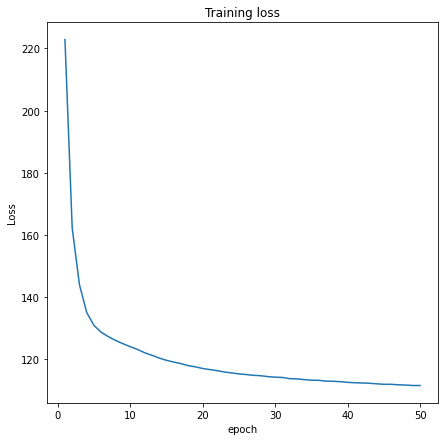

In [13]:
%%time

num_epochs = 50
training_loss = []

vae.train()

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        if(train_on_gpu):
            data = data.cuda()

        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    training_loss.append((train_loss/len(data_loader.dataset)))

    #print('Epoch [{:2d}/{:2d}] | Average loss: {:6.4f}'.format(
    #        epoch+1, num_epochs, train_loss/len(data_loader.dataset)))
    
draw_loss_curve(training_loss)

## Visualizing the effect of the dimensions

In [14]:
def test_on_dim(dim=0, samples_count=22):
    samples_num = samples_count

    ran = np.random.uniform(0, 1, size=3)
    z = [ran.copy() for _ in range(samples_num)]

    dim_of_intrest = dim
    for i in range(samples_num):
        z[i][dim_of_intrest] = -5 + i*0.5

    z = np.array(z)

    z = torch.tensor(z)

    if(train_on_gpu):
        z = z.cuda()

    gen = vae.decoder(z.float())

    fig = plt.figure(figsize=(28, 6))
    for i in range(samples_num):
        ax = fig.add_subplot(2, np.ceil(samples_num/2), i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(gen[i].detach().cpu().reshape(-1,28,28)), cmap='gray')
        lab = z[i].detach().cpu().numpy()
        ax.set_title("z=[{:1.4f}, {:1.4f}, {:1.4f}]".format(lab[0], lab[1], lab[2]), fontsize=8);

## Visualizing the effect of the 1st dimensions

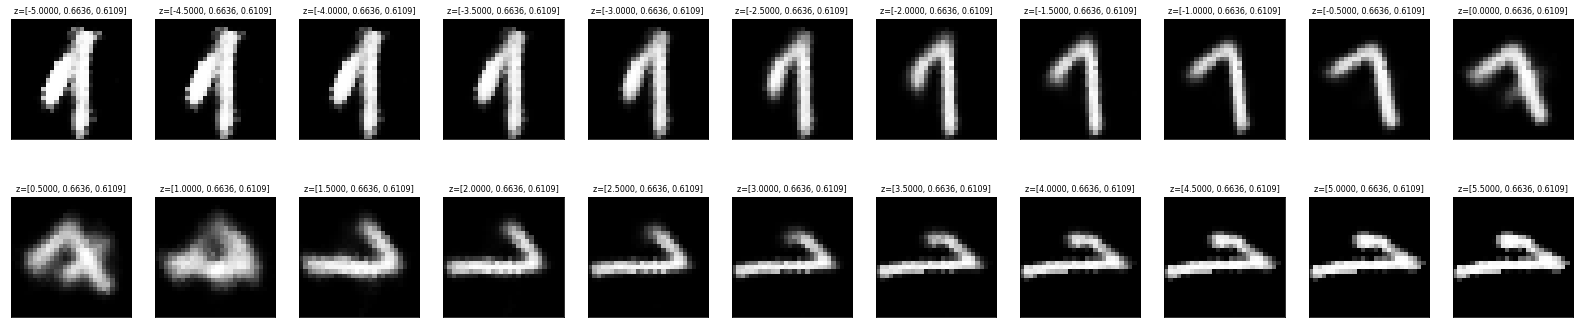

In [15]:
test_on_dim(0)

## Visualizing the effect of the 2nd dimensions

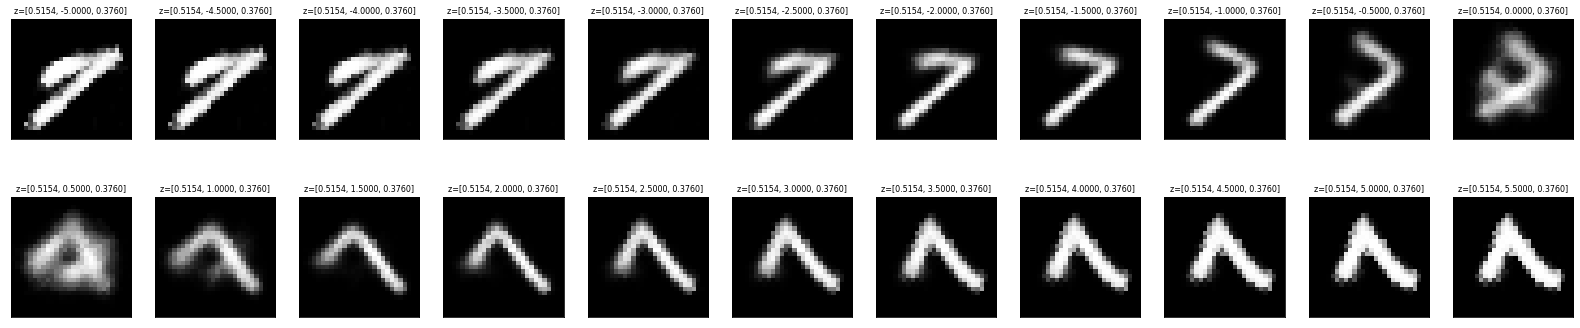

In [16]:
test_on_dim(1)

## Visualizing the effect of the 3rd dimensions

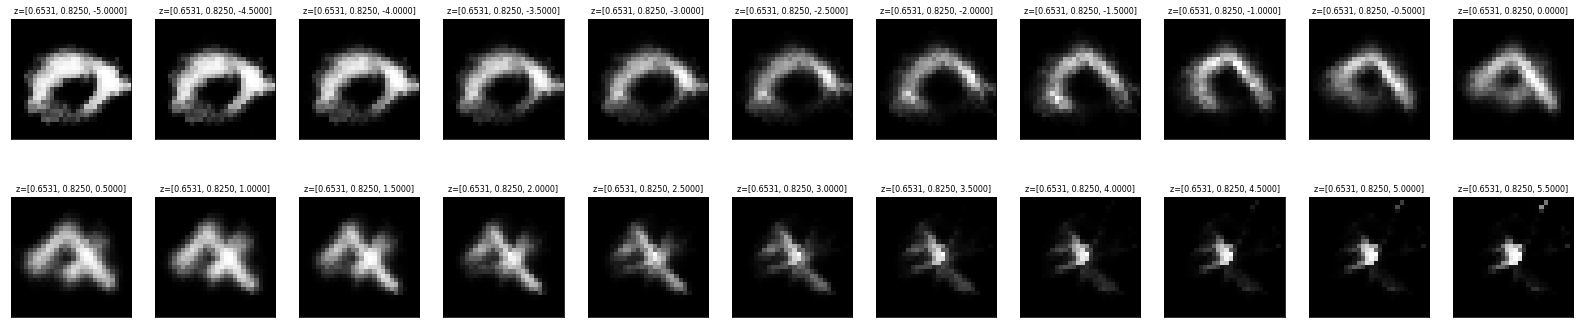

In [17]:
test_on_dim(2)

## It seems that the 2nd dimension is responsible for the change that affected the poor sevens (some rotations, and variation in stocks lengths)

### Stretching out the gradually changing effect

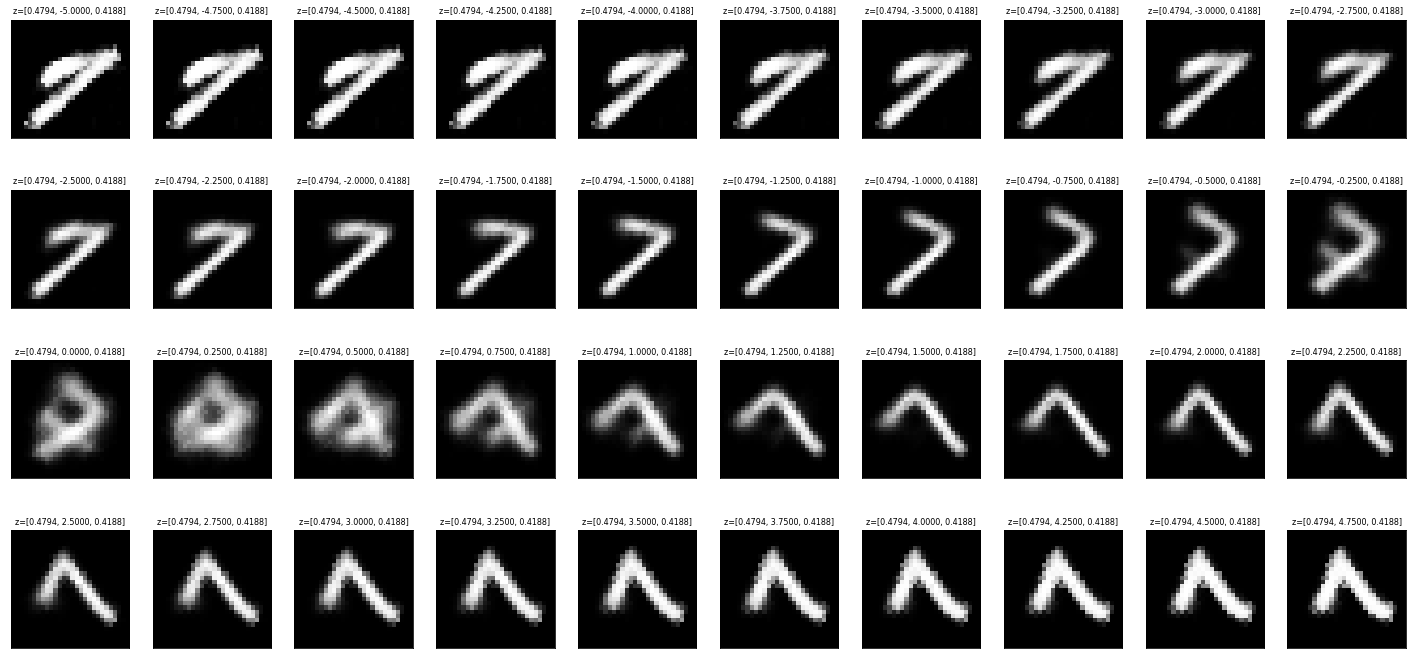

In [19]:
samples_num = 40

ran = np.random.uniform(0, 1, size=3)
z = [ran.copy() for _ in range(samples_num)]

dim_of_intrest = 1
for i in range(samples_num):
    z[i][dim_of_intrest] = -5 + i*0.25

z = np.array(z)

z = torch.tensor(z)

if(train_on_gpu):
    z = z.cuda()

gen = vae.decoder(z.float())

fig = plt.figure(figsize=(25, 12))
for i in range(samples_num):
    ax = fig.add_subplot(4, samples_num//4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(gen[i].detach().cpu().reshape(-1,28,28)), cmap='gray')
    lab = z[i].detach().cpu().numpy()
    ax.set_title("z=[{:1.4f}, {:1.4f}, {:1.4f}]".format(lab[0], lab[1], lab[2]), fontsize=8);